In [ ]:
!wget -O ./ldm_uncond/ldm-celebahq-256/unet/diffusion_pytorch_model.bin https://huggingface.co/CompVis/ldm-celebahq-256/resolve/main/unet/diffusion_pytorch_model.bin
!wget -O ./ldm_uncond/ldm-celebahq-256/vqvae/diffusion_pytorch_model.bin https://huggingface.co/CompVis/ldm-celebahq-256/resolve/main/vqvae/diffusion_pytorch_model.bin

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import re
import torch

from collections import OrderedDict
from ldm_uncond.latent_diffusion_uncond import LDMPipeline
from ldm_uncond.model.unet import UNet2DModel
from ldm_uncond.model.vq import VQModel
from ldm_uncond.model.ddim_scheduler import DDIMScheduler
from ldm_uncond.model.eulera_scheduler import EulerAncestralDiscreteScheduler

In [2]:
## Initialize models and load weights

unet_root = "ldm_uncond/ldm-celebahq-256/unet/"
vqvae_root = "ldm_uncond/ldm-celebahq-256/vqvae/"
scheduler_root = "ldm_uncond/ldm-celebahq-256/scheduler/"

with open(unet_root + "config.json", 'r') as f:
    unet_config = json.load(f)
with open(vqvae_root + "config.json", 'r') as f:
    vqvae_config = json.load(f)
with open(scheduler_root + "scheduler_config.json", 'r') as f:
    scheduler_config = json.load(f)


unet = UNet2DModel(**unet_config)
vqvae = VQModel(**vqvae_config)
scheduler = DDIMScheduler(**scheduler_config)
# scheduler = EulerAncestralDiscreteScheduler(**scheduler_config)


unet_state_dict = torch.load(unet_root + "diffusion_pytorch_model.bin", map_location='cpu')
unet_state_dict_new = OrderedDict()

for k, v in unet_state_dict.items():
    if k.startswith("mid_block.resnets.0"):
        name = k.replace('resnets.0', 'resnets_0')
    elif k.startswith("mid_block.resnets"):
        i = int(k[18])
        name = k[:18] + str(i-1) + k[19:]
    else:
        name = k
    unet_state_dict_new[name] = v

unet.load_state_dict(unet_state_dict_new)


vqvae_state_dict = torch.load(vqvae_root + "diffusion_pytorch_model.bin", map_location='cpu')
vqvae_state_dict_new = OrderedDict()

for k, v in vqvae_state_dict.items():
    if "mid_block.resnets.0" in k:
        name = k.replace('resnets.0', 'resnets_0')
    elif "mid_block.resnets" in k:
        name = re.sub(r"resnets.(\d+)", lambda match: "resnets." + str(int(match.group(1))-1), k)
    else:
        name = k
    vqvae_state_dict_new[name] = v


vqvae.load_state_dict(vqvae_state_dict_new)


del unet_state_dict, unet_state_dict_new, vqvae_state_dict, vqvae_state_dict_new

diffusion_pipeline = LDMPipeline(vqvae, unet, scheduler)

# Jetson - Generate Sample

In [38]:
DTYPE = torch.float16
DEVICE = torch.device('cuda')
diffusion_pipeline.num_inference_steps = 20

diffusion_pipeline = diffusion_pipeline.to(device=DEVICE, dtype=DTYPE)
diffusion_pipeline.eval()
diffusion_pipeline.warmup()

In [39]:
%%time
## Generate sample

noise = torch.randn((1, 3, 64, 64), dtype=DTYPE, device=DEVICE)
# with torch.cuda.amp.autocast():
sample = diffusion_pipeline(noise)

CPU times: user 4.59 s, sys: 4.93 s, total: 9.52 s
Wall time: 36.1 s


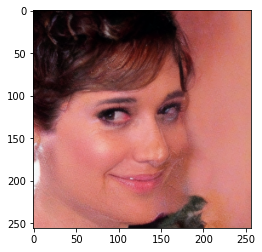

In [40]:
## Visualize sample

import matplotlib.pyplot as plt
import numpy as np

plt.imshow(sample.cpu().float().numpy()[0]/255)

### Evaluation

In [3]:
import torch
import torch.onnx
import torchvision.models as models

In [5]:
DTYPE = torch.float16
DEVICE = torch.device('cuda')
diffusion_pipeline.num_inference_steps = 20
BATCH_SIZE = 1

diffusion_pipeline = diffusion_pipeline.to(device=DEVICE, dtype=DTYPE)
diffusionModel = diffusion_pipeline.eval()
dummy_input = torch.randn((BATCH_SIZE, 3, 64, 64), dtype=DTYPE, device=DEVICE)

In [ ]:
# export the model to ONNX
torch.onnx.export(diffusionModel, dummy_input, "diffusionModel.onnx", opset_version=11, verbose=False)

/opt/project/ldm_uncond/latent_diffusion_uncond.py:25: TracerWarning: Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might lead to errors or silently give incorrect results).
  for t in self.scheduler.timesteps:
/opt/project/ldm_uncond/latent_diffusion_uncond.py:26: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  print(f"Timestep = {t.item()}\r", end="")


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2359: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  _verify_batch_size([input.size(0) * input.size(1) // num_groups, num_groups] + list(input.size()[2:]))
/opt/project/ldm_uncond/model/attention.py:42: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  tensor = tensor.reshape(ba

In [15]:
# load the pretrained model
resnet50 = models.resnet50(pretrained=True, progress=False).eval()

In [3]:
BATCH_SIZE=32

dummy_input=torch.randn(BATCH_SIZE, 3, 224, 224)

In [4]:
# export the model to ONNX
torch.onnx.export(resnet50, dummy_input, "resnet50_pytorch.onnx", verbose=False)

In [32]:
TRT_LOGGER = trt.Logger()

def build_engine(onnx_file_path, engine_file_path):
    """Takes an ONNX file and creates a TensorRT engine to run inference with"""
    with trt.Builder(TRT_LOGGER) as builder, builder.create_network(
        1 << (int)(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH)
    ) as network, builder.create_builder_config() as config, trt.OnnxParser(
        network, TRT_LOGGER
    ) as parser, trt.Runtime(
        TRT_LOGGER
    ) as runtime:
        config.max_workspace_size = 1 << 100
        builder.max_batch_size = 1
        # Parse model file
        if not os.path.exists(onnx_file_path):
            print(
                "ONNX file {} not found.".format(onnx_file_path)
            )
            exit(0)
        print("Loading ONNX file from path {}...".format(onnx_file_path))
        with open(onnx_file_path, "rb") as model:
            print("Beginning ONNX file parsing")
            if not parser.parse(model.read()):
                print("ERROR: Failed to parse the ONNX file.")
                for error in range(parser.num_errors):
                    print(parser.get_error(error))
                return None
        # The actual resnet50_pytorch.onnx is generated with batch size 32. Reshape input to batch size 1
        network.get_input(0).shape = [1, 3, 224, 224]
        print("Completed parsing of ONNX file")
        print("Building an engine from file {}; this may take a while...".format(onnx_file_path))
        plan = builder.build_serialized_network(network, config)
        engine = runtime.deserialize_cuda_engine(plan)
        print("Completed creating Engine")
        with open(engine_file_path, "wb") as f:
            f.write(plan)
        return engine

In [33]:
import tensorrt as trt
import onnx
import os

# Define file paths
model_file = 'resnet50_pytorch.onnx'
engine_file = 'resnet50_pytorch.trt'

build_engine(model_file, engine_file)

TypeError: (): incompatible function arguments. The following argument types are supported:
    1. (arg0: tensorrt.tensorrt.IBuilderConfig, arg1: int) -> None

Invoked with: <tensorrt.tensorrt.IBuilderConfig object at 0x7f534d58f0>, 1267650600228229401496703205376

In [21]:
dir(parser)

['__class__',
 '__del__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'clear_errors',
 'get_error',
 'num_errors',
 'parse',
 'parse_from_file',
 'parse_with_weight_descriptors',
 'supports_model',
 'supports_operator']

In [9]:
import tensorrt as trt
import onnx

# Load the ONNX model
model_file = 'resnet50_pytorch.onnx'
onnx_model = onnx.load(model_file)

# Create a TensorRT builder object
EXPLICIT_BATCH = 1 << (int)(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH)
builder = trt.Builder(trt.Logger(trt.Logger.ERROR))
builder_flag = builder.create_builder_config()
builder_flag.max_workspace_size = 1 << 30 # 1GB
builder_flag.flags |= EXPLICIT_BATCH  # set the flag to use explicit batch

# Create a TensorRT network from the ONNX model
network = builder.create_network(flags=EXPLICIT_BATCH)
parser = trt.OnnxParser(network, builder.logger)
success = parser.parse(onnx_model.SerializeToString())

if not success:
    print("ERROR: Failed to parse ONNX model")
    for error in range(parser.num_errors):
        print(parser.get_error(error))
    exit(1)

# Set up the input and output bindings
input_shape = (1, 3, 224, 224)
output_shape = (1, 1000)
input_tensor = network.get_input(0)
input_tensor.shape = input_shape
output_tensor = network.get_output(0)
output_tensor.shape = output_shape
bindings = [None] * 2
bindings[0] = input_tensor
bindings[1] = output_tensor

# Build the TensorRT engine
serialized_engine = builder.build_serialized_network(network, builder_flag)
                              
# Check if the engine building process failed
if serialized_engine is None:
    print("ERROR: Failed to build TensorRT engine!")
    for error in builder.error_recorder:
        print(error)
    exit(1)

# Serialize the engine to a file
engine_file = 'resnet50_pytorch.trt'
with open(engine_file, 'wb') as f:
    f.write(serialized_engine)

ERROR: Failed to build TensorRT engine!


TypeError: 'NoneType' object is not iterable

# TorchScript Compilation

In [ ]:
DTYPE = torch.float32
DEVICE = torch.device('cpu')

diffusion_pipeline = diffusion_pipeline.to(device=DEVICE, dtype=DTYPE)

with torch.no_grad():
    diffusion_pipeline.eval()
    example = torch.randn((1, 3, 64, 64),  dtype=DTYPE, device=DEVICE)
    torchscript_model = torch.jit.trace(diffusion_pipeline, example)

torch.jit.save(torchscript_model, "model_unoptimized.ptl")

In [2]:
# Might need to restart kernel after the previous cell to prevent running out of memory

# Optimize for mobile

from torch.utils.mobile_optimizer import optimize_for_mobile

torchscript_model = torch.jit.load("model_unoptimized.ptl")
torchscript_model_optimized = optimize_for_mobile(torchscript_model)
torch.jit.save(torchscript_model_optimized, "model.ptl")
torchscript_model_optimized._save_for_lite_interpreter("model_lite.ptl")

In [6]:
with torch.no_grad():
    noise = torch.randn((1, 3, 64, 64), dtype=DTYPE, device=DEVICE)
    mobile_output = torchscript_model_optimized(noise)

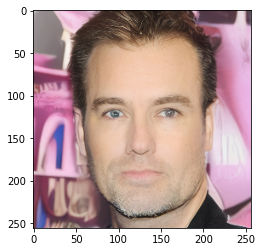

In [7]:
import matplotlib.pyplot as plt
plt.imshow(mobile_output.numpy()[0]/255)

In [ ]:
# TODO: Load correct weights - done
# TODO: make GPU compatible - done
# TODO: Use fp16 - done
# TODO: Compare outputs to test correctness - done
# TODO: Make better scheduler work